Knudson et al., (2021). PyEI: A Python package for ecological inference. Journal of Open Source Software, 6(64), 3397, https://doi.org/10.21105/joss.03397

In [32]:
import numpy as np
import pandas as pd
from pyei import TwoByTwoEI

In [33]:
race_columns = {
    'WHITE': 'WHT_NHSP22',
    'BLACK': 'BLK_NHSP22',
    'HISPANIC': 'HSP_POP22',
    'ASIAN': 'ASN_NHSP22',
}
election_columns = {
    'REPUBLICAN': 'TOT_REP',
    'DEMOCRATIC': 'TOT_DEM',
}
income_columns = ['0_35K', '35K_60K', '60K_100K', '100K_125K', '125K_150K', '150K_MORE']

### Functions

In [183]:
def calculate_population_distribution(df, race_columns, columns_to_keep):
    # Recalculate total population as the sum of race-specific columns
    df['TOTAL_POP_RECALCULATED'] = df[list(race_columns.values())].sum(axis=1)
    
    # Calculate percentages for each race column
    for race, col in race_columns.items():
        percentage_col = f"{race}_PERCENT"
        df[percentage_col] = df[col] / df['TOTAL_POP_RECALCULATED']
    
    # Add the percentage columns to the columns_to_keep list
    columns_to_keep += [f"{race}_PERCENT" for race in race_columns.keys()]

    return df[columns_to_keep]




In [184]:
def calculate_voting_distribution(df, election_columns, columns_to_keep):
    df['TOTAL_VOTES_RECALCULATED'] = df[list(election_columns.values())].sum(axis=1)
    
    for party, col in election_columns.items():
        percentage_col = f"{party}_PERCENT"
        df[percentage_col] = (df[col] / df['TOTAL_VOTES_RECALCULATED'])
    columns_to_keep += [f"{party}_PERCENT" for party in election_columns.keys()]
    return df[columns_to_keep]

In [185]:
def calculate_income_distribution(df, income_columns, columns_to_keep):
    df['TOTAL_INCOME_POPULATION'] = df[income_columns].sum(axis=1)
    
    for income_range in income_columns:
        percentage_col = f"{income_range}_PERCENT"
        df[percentage_col] = df[income_range] / df['TOTAL_INCOME_POPULATION']
    
    columns_to_keep += [f"{income_range}_PERCENT" for income_range in income_columns]

    return df[columns_to_keep]

In [186]:
def run_ecological_inference(
    df, 
    demographic_col, 
    voting_col, 
    total_votes_col, 
    demographic_group_name="Demographic Group", 
    candidate_name="Candidate", 
    precinct_col="UNIQUE_ID",
    model_name="king99_pareto_modification",
    pareto_scale=30,
    pareto_shape=1.0
):
    # Extract data
    X = np.array(df[demographic_col])  # Demographic percentage
    T = np.array(df[voting_col])       # Voting percentage
    N = np.array(df[total_votes_col])  # Total votes
    precinct_names = df[precinct_col]  # Precinct names

    ei = TwoByTwoEI(
        model_name=model_name,
        pareto_scale=pareto_scale,
        pareto_shape=pareto_shape
    )

    # Fit the model
    ei.fit(
        X, T, N,
        demographic_group_name=demographic_group_name,
        candidate_name=candidate_name,
        precinct_names=precinct_names,
        draws=8000,
        tune=4000,
        target_accept=0.95
    )

    # Display a summary
    summary = ei.summary()
    print(summary)

    return ei, summary


## South Carolina

### Import data

In [209]:
sc_election_gov_df = pd.read_json('states/south_carolina/election/sc_election_gov_22.json')
sc_race_df = pd.read_json('states/south_carolina/demographics/south_carolina_precincts_racial_population.json')
sc_economic_df = pd.read_json('states/south_carolina/economic/south_carolina_precincts_household_income.json')
sc_region_type_df = pd.read_json('states/south_carolina/geodata/south_carolina_precincts_region_type.json')

In [210]:
sc_candidate_mapping = {
    'REPUBLICAN': 'Henry McMaster',
    'DEMOCRATIC': 'Joe Cunningham'
}

### Main Script

#### Preprocess data

##### Racial Group

In [211]:
print(sc_race_df.columns.values)

['UNIQUE_ID' 'NAME' 'Prec_Code' 'CONG_DIST' 'TOT_POP22' 'NHSP_POP22'
 'HSP_POP22' 'WHT_NHSP22' 'BLK_NHSP22' 'ASN_NHSP22' 'OTH_NHSP22']


In [212]:
columns_to_keep = ['UNIQUE_ID', 'TOT_POP22']

In [213]:
sc_race_with_percentages = calculate_population_distribution(sc_race_df, race_columns, columns_to_keep)

In [214]:
columns_to_keep = ['UNIQUE_ID', 'TOT_VOT']

In [215]:
sc_election_gov_with_percentages = calculate_voting_distribution(sc_election_gov_df, election_columns, columns_to_keep)

In [216]:
sc_race_merged_ei_df = pd.merge(sc_election_gov_with_percentages, sc_race_with_percentages, on='UNIQUE_ID', how='left')

In [217]:
sc_race_merged_ei_df.fillna(0, inplace=True)

In [218]:
print(sc_race_merged_ei_df)

                    UNIQUE_ID  TOT_VOT  REPUBLICAN_PERCENT  \
0     ABBEVILLE_PRECINCT_001_      975            0.736410   
1     ABBEVILLE_PRECINCT_002_      628            0.356688   
2     ABBEVILLE_PRECINCT_003_      574            0.585366   
3     ABBEVILLE_PRECINCT_004_      437            0.723112   
4     ABBEVILLE_PRECINCT_005_      722            0.829640   
...                       ...      ...                 ...   
2256  CLARENDON_PRECINCT_024_      600            0.430000   
2257   BARNWELL_PRECINCT_016_        0            0.000000   
2258   BERKELEY_PRECINCT_099_        0            0.000000   
2259   BERKELEY_PRECINCT_098_        0            0.000000   
2260      AIKEN_PRECINCT_000_        0            0.000000   

      DEMOCRATIC_PERCENT  TOT_POP22  WHITE_PERCENT  BLACK_PERCENT  \
0               0.263590       1290       0.651800       0.348200   
1               0.643312        901       0.088790       0.826859   
2               0.414634       1297       0.4968

In [219]:
# print max value of BLACK_PERCENT
print(sc_race_merged_ei_df['BLACK_PERCENT'].min())

0.0


In [220]:
print(sc_race_merged_ei_df)

                    UNIQUE_ID  TOT_VOT  REPUBLICAN_PERCENT  \
0     ABBEVILLE_PRECINCT_001_      975            0.736410   
1     ABBEVILLE_PRECINCT_002_      628            0.356688   
2     ABBEVILLE_PRECINCT_003_      574            0.585366   
3     ABBEVILLE_PRECINCT_004_      437            0.723112   
4     ABBEVILLE_PRECINCT_005_      722            0.829640   
...                       ...      ...                 ...   
2256  CLARENDON_PRECINCT_024_      600            0.430000   
2257   BARNWELL_PRECINCT_016_        0            0.000000   
2258   BERKELEY_PRECINCT_099_        0            0.000000   
2259   BERKELEY_PRECINCT_098_        0            0.000000   
2260      AIKEN_PRECINCT_000_        0            0.000000   

      DEMOCRATIC_PERCENT  TOT_POP22  WHITE_PERCENT  BLACK_PERCENT  \
0               0.263590       1290       0.651800       0.348200   
1               0.643312        901       0.088790       0.826859   
2               0.414634       1297       0.4968

##### Economic Group

In [221]:
columns_to_keep = ['UNIQUE_ID']

In [222]:
sc_economic_with_percentages = calculate_income_distribution(sc_economic_df, income_columns, columns_to_keep)

In [223]:
sc_economic_merged_ei_df = pd.merge(sc_election_gov_with_percentages, sc_economic_with_percentages, on='UNIQUE_ID', how='left')

In [224]:
sc_economic_merged_ei_df.fillna(0, inplace=True)

In [90]:
print(sc_economic_merged_ei_df)

                    UNIQUE_ID  TOT_VOT  REPUBLICAN_PERCENT  \
0     ABBEVILLE_PRECINCT_001_      975            0.736410   
1     ABBEVILLE_PRECINCT_002_      628            0.356688   
2     ABBEVILLE_PRECINCT_003_      574            0.585366   
3     ABBEVILLE_PRECINCT_004_      437            0.723112   
4     ABBEVILLE_PRECINCT_005_      722            0.829640   
...                       ...      ...                 ...   
2256  CLARENDON_PRECINCT_024_      600            0.430000   
2257   BARNWELL_PRECINCT_016_        0            0.000000   
2258   BERKELEY_PRECINCT_099_        0            0.000000   
2259   BERKELEY_PRECINCT_098_        0            0.000000   
2260      AIKEN_PRECINCT_000_        0            0.000000   

      DEMOCRATIC_PERCENT  0_35K_PERCENT  35K_60K_PERCENT  60K_100K_PERCENT  \
0               0.263590       0.208333         0.200000          0.276667   
1               0.643312       0.472222         0.418981          0.069444   
2               0.414

### Running EI models

#### Racial Run

##### DEMOCRATIC Run

In [225]:
dem_white_ei, dem_white_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.937690
Sampling...


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

Sampling time = 0:00:05.897616
Transforming variables...
Transformation time = 0:05:15.894358


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Joe Cunningham is
        0.293
        The posterior mean for the district-level voting preference of
        non-White for Joe Cunningham is
        0.650
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Joe Cunningham is
        [0.28978181 0.29664728]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Joe Cunningham is
        [0.64297994 0.65596905]
        


In [95]:
dem_black_ei, dem_black_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:03.081997
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:04.432855
Transforming variables...
Transformation time = 0:07:23.283963


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Joe Cunningham is
        0.800
        The posterior mean for the district-level voting preference of
        non-Black for Joe Cunningham is
        0.308
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Joe Cunningham is
        [0.78959029 0.80948246]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Joe Cunningham is
        [0.30505911 0.31100068]
        


In [131]:
dem_asian_ei, dem_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.089201
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:04.251924
Transforming variables...
Transformation time = 0:04:01.554763


Model: king99
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Joe Cunningham is
        0.836
        The posterior mean for the district-level voting preference of
        non-Asian for Joe Cunningham is
        0.405
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Joe Cunningham is
        [0.7139257  0.95522012]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Joe Cunningham is
        [0.40307708 0.40731148]
        


In [97]:
dem_hispanic_ei, rep_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:04.009427
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:04.696826
Transforming variables...
Transformation time = 0:04:28.059731


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Joe Cunningham is
        0.596
        The posterior mean for the district-level voting preference of
        non-Hispanic for Joe Cunningham is
        0.402
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Joe Cunningham is
        [0.5550421  0.63822447]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Joe Cunningham is
        [0.39947856 0.40437012]
        


##### Running Repulican

In [98]:
rep_white_ei, rep_white_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:06.690252
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:07.337865
Transforming variables...
Transformation time = 0:05:59.313321


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Henry McMaster is
        0.708
        The posterior mean for the district-level voting preference of
        non-White for Henry McMaster is
        0.346
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Henry McMaster is
        [0.70299458 0.71219493]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Henry McMaster is
        [0.33693715 0.35445358]
        


In [99]:
rep_black_ei, rep_black_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:03.725277
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:02.888504
Transforming variables...
Transformation time = 0:08:43.940381


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Henry McMaster is
        0.200
        The posterior mean for the district-level voting preference of
        non-Black for Henry McMaster is
        0.692
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Henry McMaster is
        [0.19054156 0.21028299]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Henry McMaster is
        [0.68885341 0.694906  ]
        


In [100]:
rep_asian_ei, rep_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:03.220240
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.342221
Transforming variables...
Transformation time = 0:10:03.618678


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Henry McMaster is
        0.154
        The posterior mean for the district-level voting preference of
        non-Asian for Henry McMaster is
        0.595
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Henry McMaster is
        [0.07241698 0.26153371]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Henry McMaster is
        [0.59298862 0.59645021]
        


In [101]:
rep_hispanic_ei, rep_hispanic_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...


Compilation time = 0:00:02.412759
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.219482
Transforming variables...
Transformation time = 0:05:36.621691


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Henry McMaster is
        0.402
        The posterior mean for the district-level voting preference of
        non-Hispanic for Henry McMaster is
        0.598
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Henry McMaster is
        [0.35795485 0.44658988]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Henry McMaster is
        [0.59542968 0.60060079]
        


#### Econ Run

##### Dem Run

In [102]:
dem_0_35_ei, dem_0_35_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.843128
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.310918
Transforming variables...
Transformation time = 0:06:40.460200


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Joe Cunningham is
        0.579
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Joe Cunningham is
        0.364
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Joe Cunningham is
        [0.56568255 0.59138583]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Joe Cunningham is
        [0.36046272 0.36826613]
        


In [103]:
dem_35_60_ei, dem_35_60_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.894709
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:04.109127
Transforming variables...
Transformation time = 0:06:23.283481


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham is
        0.535
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham is
        0.386
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham is
        [0.51645295 0.55325479]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham is
        [0.38213227 0.39035371]
        


In [104]:
dem_60_100_ei, dem_60_100_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.914831
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:04.325344
Transforming variables...
Transformation time = 0:06:10.106624


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham is
        0.439
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham is
        0.404
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham is
        [0.4219112  0.45725576]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham is
        [0.39922377 0.40900764]
        


In [105]:
dem_100_125_ei, dem_100_125_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.710333
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.468791
Transforming variables...
Transformation time = 0:16:28.147497


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Joe Cunningham is
        0.318
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham is
        0.420
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Joe Cunningham is
        [0.27782046 0.35715537]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham is
        [0.41598483 0.42400446]
        


In [106]:
dem_125_150_ei, dem_125_150_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:03.249298
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.295317
Transforming variables...
Transformation time = 0:03:24.871926


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Joe Cunningham is
        0.178
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham is
        0.427
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Joe Cunningham is
        [0.13464954 0.22792286]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham is
        [0.42299817 0.42958765]
        


In [107]:
dem_150_more_ei, dem_150_more_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.595682
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:02.770345
Transforming variables...
Transformation time = 0:21:38.321431


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Joe Cunningham is
        0.333
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Joe Cunningham is
        0.426
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Joe Cunningham is
        [0.31148362 0.35544478]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Joe Cunningham is
        [0.42103775 0.43003333]
        


##### Rep Run

In [108]:
rep_0_35_ei, rep_0_35_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.987195
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:05.078418
Transforming variables...
Transformation time = 0:06:37.801745


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Henry McMaster is
        0.421
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Henry McMaster is
        0.636
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Henry McMaster is
        [0.40811213 0.43432501]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Henry McMaster is
        [0.6316824 0.6395299]
        


In [109]:
rep_35_60_ei, rep_35_60_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.888087
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:04.404466
Transforming variables...
Transformation time = 0:06:06.961842


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        0.465
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        0.614
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        [0.44580868 0.48313666]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        [0.60962786 0.61789641]
        


In [110]:
rep_60_100_ei, rep_60_100_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.554345
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:02.798209
Transforming variables...
Transformation time = 0:07:25.927757


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        0.561
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        0.596
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        [0.54286142 0.5787003 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        [0.5907824  0.60068228]
        


In [111]:
rep_100_125_ei, rep_100_125_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:02.936834
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.379361
Transforming variables...
Transformation time = 0:03:18.120344


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Henry McMaster is
        0.682
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster is
        0.580
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Henry McMaster is
        [0.64066039 0.72091779]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster is
        [0.57601205 0.58420185]
        


In [112]:
rep_125_150_ei, rep_125_150_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:02.981398
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:03.177475
Transforming variables...
Transformation time = 0:19:43.990378


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Henry McMaster is
        0.820
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster is
        0.573
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Henry McMaster is
        [0.77197115 0.85931032]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster is
        [0.57067271 0.57690401]
        


In [113]:
rep_150_more_ei, rep_150_more_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:03.889405
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:00:06.936590
Transforming variables...
Transformation time = 0:54:23.245721


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Henry McMaster is
        0.666
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Henry McMaster is
        0.574
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Henry McMaster is
        [0.64269046 0.68986098]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Henry McMaster is
        [0.56965941 0.5792319 ]
        


### Ploting

<Axes: title={'center': 'Support for Henry McMaster'}>

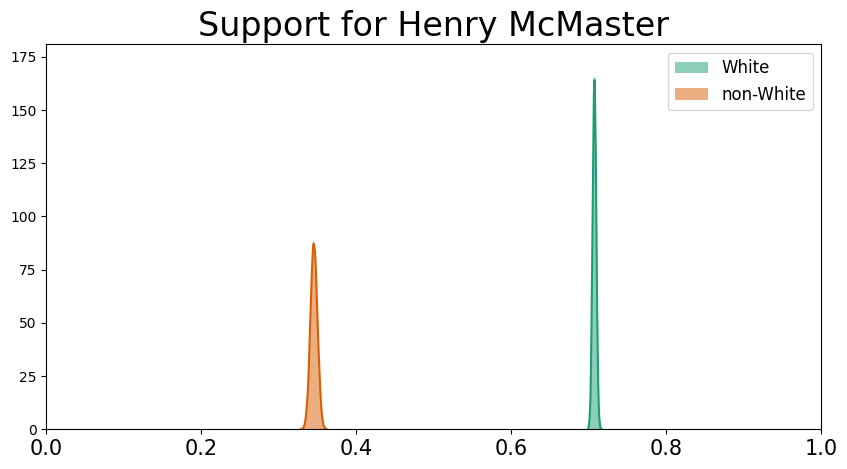

In [207]:
rep_white_ei.plot_kde()

### Export data